In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm
import math
import re
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import pandas as pd
import random

max_seq_length = 40

In [82]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

In [83]:
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

In [84]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


In [85]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2


In [86]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        
        #self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)
        self.pos_encoding = PositionalEncoding(position=max_seq_length, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

In [87]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

In [88]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # vocab_size에 맞추지않고 최대 시퀀스 길이
        #self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)
        self.pos_encoding = PositionalEncoding(position=max_seq_length, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

In [89]:
# 데이터 폴더 경로
path = 'ChatbotData.csv'

label
0    5290
1    3570
2    2963
Name: count, dtype: int64


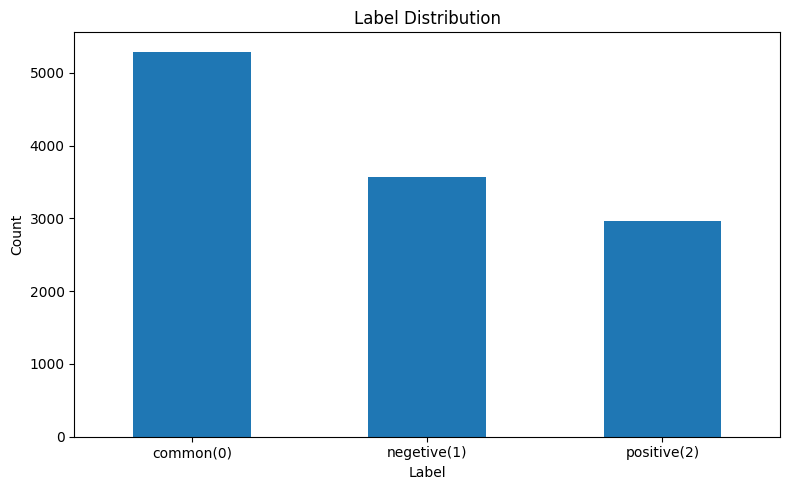

'\n라벨 마다 갯수 차이가 남\n0번 레이블의 답변이 매끄럽지 않을까? 하는 생각이 듦\n'

In [90]:
df = pd.read_csv('ChatbotData.csv')

# 레이블 분포 확인
print(df['label'].value_counts())

# 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
df['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['common(0)', 'negetive(1)', 'positive(2)'], rotation=0)
plt.tight_layout()
plt.show()


'''
라벨 마다 갯수 차이가 남
0번 레이블의 답변이 매끄럽지 않을까? 하는 생각이 듦
'''

In [91]:
def preprocess_sentence(sentence):
    # 1. 유니코드 정규화
    sentence = unicodedata.normalize("NFC", sentence)

    # 2. 문장부호 앞뒤에 공백 삽입
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"\s+", " ", sentence)

    # 3. 허용 문자만 유지 (한글, 자모, 영문, 숫자, 공백, 주요 문장부호)
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣA-Za-z0-9?.!,~… ]", " ", sentence)

    # 4. 감정 표현 반복 상한 (4개 이상 → 2개)
    sentence = re.sub(r'(ㅋ)\1{3,}', r'\1\1', sentence)
    sentence = re.sub(r'(ㅎ)\1{3,}', r'\1\1', sentence)
    sentence = re.sub(r'(ㅠ)\1{3,}', r'\1\1', sentence)
    sentence = re.sub(r'(ㅜ)\1{3,}', r'\1\1', sentence)

    # 5. 공백 정리
    sentence = re.sub(r"\s+", " ", sentence).strip()
    return sentence

In [92]:
def load_chatbot_csv(path,preprocess_sentence):
    """
    반환: [(Q_clean, A_clean, label), ...]
    """
    df = pd.read_csv(path)
    qs = df["Q"].astype(str).map(preprocess_sentence)
    as_ = df["A"].astype(str).map(preprocess_sentence)
    labels = df["label"].astype(int)
    return list(zip(qs, as_, labels))

In [93]:
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

In [94]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [95]:
data = load_chatbot_csv(path, preprocess_sentence)

with open("clean_corpus.txt", "w", encoding="utf-8") as f:
    for q, a, label in data:
        if q and a:
            f.write(f"{label}\t{q}\t{a}\n")

print("clean_corpus.txt 생성 완료")

clean_corpus.txt 생성 완료


In [96]:
spm.SentencePieceTrainer.Train(
    input='clean_corpus.txt',
    model_prefix="chatbot_spm",
    vocab_size=16000,
    character_coverage=0.9995,
    model_type="bpe",  # 한국어면 unigram도 가능
    max_sentence_length=999999,

    # 특수 토큰 ID 설정
    pad_id=0,   # <pad>
    unk_id=1,   # <unk>
    bos_id=2,   # <s>
    eos_id=3,   # </s>

    # label을 포함한 사용자 정의 토큰
    user_defined_symbols=[
        "<label_0>", "<label_1>", "<label_2>",
    ]
)

'''
감정 label이 존재하여, 

spm에서 label을 포함한 사용자 정의 토큰 정의

label_token = self.label_map[label] 으로 

spm 모델에 정의된 토큰 ID를 동적으로 가져오는 부분 추가

따라서 인코더 토큰 'enc_input'에 
q_tokens = [label_token] + [bos_id] + q_ids + [eos_id] 을 할당하는 코드 추가

>>> 감정 + Q 형태로 학습 진행됨을 확인

'''

"\n감정 label이 존재하여, \n\nspm에서 label을 포함한 사용자 정의 토큰 정의\n\nlabel_token = self.label_map[label] 으로 \n\nspm 모델에 정의된 토큰 ID를 동적으로 가져오는 부분 추가\n\n따라서 인코더 토큰 'enc_input'에 \nq_tokens = [label_token] + [bos_id] + q_ids + [eos_id] 을 할당하는 코드 추가\n\n>>> 감정 + Q 형태로 학습 진행됨을 확인\n\n"

In [97]:
sp = spm.SentencePieceProcessor()
sp.Load("chatbot_spm.model")

True

In [98]:
print(sp.piece_to_id("<label_0>"), sp.piece_to_id("<label_1>"), sp.piece_to_id("<label_2>"))

# label 0,1,2 가 토큰 4,5,6에 매핑됨을 확인

4 5 6


In [ ]:
class ChatbotDataset(Dataset):
    def __init__(self, data, sp, max_length=40):
        self.sp = sp
        self.max_length = max_length
        self.data = []

        # spm 모델에 정의된 토큰 ID를 동적으로 가져오기
        self.label_map = {
            0: self.sp.piece_to_id('<label_0>'),
            1: self.sp.piece_to_id('<label_1>'),
            2: self.sp.piece_to_id('<label_2>')
        }

        
        for q, a, label in data:
            bos_id = self.sp.bos_id()
            eos_id = self.sp.eos_id()
            label_token = self.label_map[label]

            q_ids = self.sp.encode_as_ids(q)
            a_ids = self.sp.encode_as_ids(a)

            q_tokens = [bos_id] + [label_token] + q_ids + [eos_id] 
            # 이전[[<label_k>][BOS] Q [EOS]]  >>> 변경[[BOS][<label_k>] Q [EOS]]
            # 얼마나 성능 향상이 있었나? 
            a_tokens = [bos_id] + a_ids + [eos_id]

            if len(q_tokens) > self.max_length or len(a_tokens) > self.max_length:
                continue

            q_tokens += [self.sp.pad_id()] * (self.max_length - len(q_tokens))
            a_tokens += [self.sp.pad_id()] * (self.max_length - len(a_tokens))

            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            self.data.append({
                "enc_input": q_tokens,
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target


In [100]:
data = load_chatbot_csv(path, preprocess_sentence)
dataset = ChatbotDataset(data, sp, max_length=40)

In [101]:
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

In [102]:
for encoder_input, decoder_input, decoder_label in dataloader:
    print(encoder_input.size())
    print(decoder_input.size())
    print(decoder_label.size())
    break

torch.Size([32, 40])
torch.Size([32, 39])
torch.Size([32, 39])


In [103]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x=inputs,
            mask=enc_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

In [104]:
# 예: 하이퍼파라미터 설정
NUM_LAYERS = 4     # 인코더/디코더 층 수
D_MODEL = 512      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 2048        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.2      # 드롭아웃 비율
VOCAB_SIZE = 16000 # 단어 집합 크기(예시)

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(16000, 512)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.2, inplace=False)
    (enc_layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=512, out_features=512, bias=True)
          (key_dense): Linear(in_features=512, out_features=512, bias=True)
          (value_dense): Linear(in_features=512, out_features=512, bias=True)
          (out_dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout2): Dropout(p=0.2, inplace=False)
        (norm2): LayerNorm((512,), eps=1e-06, elementwise_

In [105]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [106]:

# 수정된 학습률 함수
'''
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        step = max(step, 1)  # 0으로 나누는 것 방지
        arg1 = step ** -0.5
        arg2 = step * (warmup_steps ** -1.5)
        return (d_model ** -0.5) * min(arg1, arg2) * 10  # 스케일 증가
    return lr_lambda

    수렴속도가 느림. 
'''
def get_lr_lambda(d_model, warmup_steps=2000):
    d_model = float(d_model)
    def lr_lambda(step):
        step = max(step, 1)
        arg1 = step ** -0.5
        arg2 = step * (warmup_steps ** -1.5)
        return (d_model ** -0.5) * min(arg1, arg2) * 15  # 10→15
    return lr_lambda

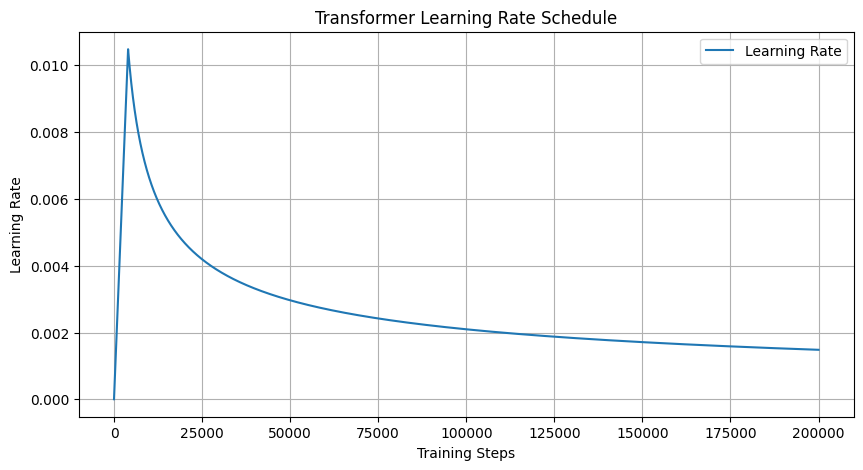

In [107]:
# 하이퍼파라미터 설정
d_model = 512
warmup_steps = 4000
total_steps = 200000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


In [108]:
# Optimizer 정의
optimizer = optim.AdamW(model.parameters(), betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=2000))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

print(device)

cuda


In [110]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [111]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 일정 스텝마다 로그 출력
            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

In [112]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=60,  # 원하는 에폭 수
    device=device
)

[Epoch 1, Step 0] Loss: 9.9298, Acc: 0.0000
[Epoch 1, Step 100] Loss: 9.3587, Acc: 0.0000
[Epoch 1, Step 200] Loss: 8.2645, Acc: 0.3057
[Epoch 1, Step 300] Loss: 7.0358, Acc: 0.3697
Epoch 1 Completed - Avg Loss: 8.4851, Avg Acc: 0.2015
[Epoch 2, Step 0] Loss: 7.1119, Acc: 0.3214
[Epoch 2, Step 100] Loss: 7.2369, Acc: 0.2891
[Epoch 2, Step 200] Loss: 6.5705, Acc: 0.3404
[Epoch 2, Step 300] Loss: 6.5419, Acc: 0.3246
Epoch 2 Completed - Avg Loss: 6.7741, Avg Acc: 0.3240
[Epoch 3, Step 0] Loss: 6.3770, Acc: 0.3277
[Epoch 3, Step 100] Loss: 6.4843, Acc: 0.3171
[Epoch 3, Step 200] Loss: 6.3091, Acc: 0.3263
[Epoch 3, Step 300] Loss: 6.1448, Acc: 0.3196
Epoch 3 Completed - Avg Loss: 6.2900, Avg Acc: 0.3257
[Epoch 4, Step 0] Loss: 6.0800, Acc: 0.3424
[Epoch 4, Step 100] Loss: 5.8052, Acc: 0.3575
[Epoch 4, Step 200] Loss: 5.5732, Acc: 0.3591
[Epoch 4, Step 300] Loss: 5.9967, Acc: 0.3279
Epoch 4 Completed - Avg Loss: 5.9199, Avg Acc: 0.3306
[Epoch 5, Step 0] Loss: 5.4322, Acc: 0.3842
[Epoch 5, St

In [124]:
def decoder_inference(model, sentence, tokenizer, device='cuda'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40

    # 전처리
    sentence = preprocess_sentence(sentence)

    # 인코더 입력: [START] + 인코딩 + [END]
    # 레이블 토큰 제거!
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            logits = model(enc_input, dec_input)
            last_step_logits = logits[:, -1, :]
            predicted_id = torch.argmax(last_step_logits, dim=-1)

            if predicted_id.item() == END_TOKEN:
                break

            predicted_id = predicted_id.unsqueeze(0)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    output_sequence = dec_input.squeeze(0).tolist()
    return output_sequence

In [125]:
def sentence_generation(model, sentence, tokenizer, device='cuda'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [126]:
def query_to_llm(num, path, model, sp, device="cuda"):
    """
    num: 생성할 문장 개수
    path: ChatbotData.csv 경로
    model: 학습된 Transformer 모델
    sp: SentencePiece tokenizer
    """
    path = "ChatbotData.csv"
    df = pd.read_csv(path)
    sentences = []

    # Q 컬럼에서 랜덤으로 num개 추출
    sample_qs = random.sample(df["Q"].tolist(), num)

    for sentence in sample_qs:
        sentence = str(sentence).strip()
        sentence_generation(model, sentence, sp, device)


In [127]:
query_to_llm(29, path, model, sp)

입력 : 이별 10일째 되어가네
출력 : 더 좋은 사람 만날 수 있을 거예요 .
입력 : 좋아하는 여자애 생각하느라 성적이 떨어짐.
출력 : 마음이 복잡하겠어요 .
입력 : 간만에 떨리니까 좋더라
출력 : 저도 좋아해요 .
입력 : 머리스타일 바꿔볼까?
출력 : 저는 마음을 전해보세요 .
입력 : 짝녀가 절 신경쓰는 것 같은 건 내 착가인가요?
출력 : 저는 마음을 전해보세요 .
입력 : 고백합니다
출력 : 다른 곳에 쓰려고 수 있어요 .
입력 : 여자친구가 잘못된건 아닌데 표현이 너무 서툴러.
출력 : 더 좋은 사람 만날 수 있을 거예요 .
입력 : 아픔을 지니고 사랑한다는 것
출력 : 좋은 생각이에요 .
입력 : 썸타다 지침
출력 : 저도 좋아해요 .
입력 : 갑자기 일어난일이라 어이 없어
출력 : 그 사람을 잊는다는 건 어떨까요 .
입력 : 여자친구가 나를 안 질려하려면 뭘 준비해야할까?
출력 : 같이 가보세요 .
입력 : 진급할 때가 된 거 같은데
출력 : 많이 지쳤나봐요 .
입력 : 죽을만큼 보고싶다.
출력 : 많이 지쳤나봐요 .
입력 : 친구가 이사하는 거 도와준대
출력 : 좋은 생각이에요 .
입력 : 돈 다 썼어
출력 : 그 사람이 있을 거예요 .
입력 : 결혼하는데 돈이 엄청 드네
출력 : 이제 일어날 더 좋은 사람 만날 수 있을 거예요 .
입력 : 냉방비 장난 아님
출력 : 많이 지쳤나봐요 .
입력 : 일이 안 끝나
출력 : 다른 사람 만날 수 있을 거예요 .
입력 : 또 다시 이별
출력 : 마음이 복잡하겠어요 .
입력 : 또 연락을 해버렸네.
출력 : 이제 일어날 마세요 .
입력 : 이 시려
출력 : 같이 가보세요 .
입력 : 헷갈리는데 유지하는 게 좋을까
출력 : 좋은 사람 만날 수 있을 거예요 .
입력 : 야근 좀 그만하고 싶어
출력 : 같이 가보세요 .
입력 : 남친 SNS에 내 사진 없어
출력 : 제가 있잖아요 .
입력 : 술 먹으러 갔는데 연락이 안돼
출력 : 혼자 사는 것도 좋을 거예요 .
입력 : 핸드폰 어플 지울까
출력 : 좋은

In [128]:
'''
데이터에서 랜덤 추출
감정 토큰을 프리픽스 시켜서 추론하는 것이 맞는것인지?
'''
'''
위 함수에서는 데이터에서 추출하였지만 real은 gpt를 통해 데이터에 존재하지않는
문장으로 추론.
'''

real = [
"오늘은 왜 이렇게 피곤하지?",
"내일 뭐 입을까?",
"밥은 먹었어?",
"요즘 너무 바빠서 힘들어.",
"주말에 뭐 할까 고민돼."
"날씨가 진짜 덥다.",
"커피를 너무 많이 마신 것 같아.",
"요즘 잠이 잘 안 와.",
"그냥 아무 생각 없이 쉬고 싶다.",
"오늘 하루는 평범했어.",
"이제 정말 끝인 것 같아.",
"연락이 점점 줄어들고 있어.",
"나만 힘든 걸까?",
"그 사람 생각이 자꾸 나.",
"미련이 남아서 괴롭다.",
"혼자 있는 게 익숙해지는 게 슬퍼.",
"마음이 식은 게 느껴져.",
"내가 뭘 잘못한 걸까.",
"아직도 그때 일이 떠올라.",
"사랑이 이렇게 아픈 줄 몰랐어.",
"오늘 그 사람 웃는 게 너무 예뻤어.",
"같이 있을 때 제일 행복해.",
"괜히 생각만 해도 기분이 좋아.",
"그 사람이랑 통화하면 하루가 즐거워져.",
"눈만 봐도 마음이 편해.",
"요즘 매일 설레.",
"사랑받는다는 느낌이 이런 걸까.",
"선물 고르면서 괜히 웃음 나왔어.",
"만나면 시간이 너무 빨리 가.",
"그냥 그 사람이 좋다.",
]

In [129]:
def decoder_inference_emo(model, sentence, tokenizer, label_id=0, device='cuda'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40

    # 전처리
    sentence = preprocess_sentence(sentence)

    # 전달받은 label_id로 label 토큰 선택
    label_token = tokenizer.piece_to_id(f'<label_{label_id}>')

    # 인코더 입력:  [START] +[LABEL] + 인코딩 + [END]
    enc_input_ids =  [START_TOKEN] + [label_token] + tokenizer.encode(sentence) + [END_TOKEN]
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력: START_TOKEN 하나로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()
    with torch.no_grad():
        for _ in range(MAX_LENGTH):
            logits = model(enc_input, dec_input)
            last_step_logits = logits[:, -1, :]
            predicted_id = torch.argmax(last_step_logits, dim=-1)

            if predicted_id.item() == END_TOKEN:
                break

            dec_input = torch.cat([dec_input, predicted_id.unsqueeze(0)], dim=1)

    return dec_input.squeeze(0).tolist()


def sentence_generation_emo(model, sentence, tokenizer, label_id=0, device='cuda'):
    """
    label_id: 0=일상, 1=이별(부정), 2=사랑(긍정)
    """
    output_seq = decoder_inference_emo(model, sentence, tokenizer, label_id=label_id, device=device)

    # START/END 등의 제어토큰 제외 후 디코딩
    predicted_sentence = tokenizer.decode(
        [t for t in output_seq if t < tokenizer.GetPieceSize()]
    )

    print(f"입력 : {sentence}")
    print(f"출력({label_id}) : {predicted_sentence}")
    return predicted_sentence


In [130]:
# 감정 토큰 x
def depends_on_emo():
    for i in real:
        sentence_generation(model, i, sp, device)
        
# 일상 다반사
def depends_on_emo_0():
    for i in real:
        sentence_generation_emo(model, i, sp, label_id=0, device=device) 
#  부정
def depends_on_emo_1():
    for i in real:
        sentence_generation_emo(model, i, sp, label_id=1, device=device)
#  긍정
def depends_on_emo_2():
    for i in real:
        sentence_generation_emo(model, i, sp, label_id=2, device=device)  
        

In [131]:
depends_on_emo()

입력 : 오늘은 왜 이렇게 피곤하지?
출력 : 많이 지쳤나봐요 .
입력 : 내일 뭐 입을까?
출력 : 저는 좋아요 .
입력 : 밥은 먹었어?
출력 : 저는 좋아요 .
입력 : 요즘 너무 바빠서 힘들어.
출력 : 더 좋은 사람 만날 수 있어요 .
입력 : 주말에 뭐 할까 고민돼.날씨가 진짜 덥다.
출력 : 제가 있잖아요 .
입력 : 커피를 너무 많이 마신 것 같아.
출력 : 너무 많이 지쳤나봐요 .
입력 : 요즘 잠이 잘 안 와.
출력 : 잘 지내고 있을 거예요 .
입력 : 그냥 아무 생각 없이 쉬고 싶다.
출력 : 이제 일어날 더 상황을 지켜보세요 .
입력 : 오늘 하루는 평범했어.
출력 : 좋은 생각이에요 .
입력 : 이제 정말 끝인 것 같아.
출력 : 좋은 생각이에요 .
입력 : 연락이 점점 줄어들고 있어.
출력 : 그 사람도 있어요 .
입력 : 나만 힘든 걸까?
출력 : 그 사람도 그럴 거예요 .
입력 : 그 사람 생각이 자꾸 나.
출력 : 마음이 좀 더 많이 지쳤나봐요 .
입력 : 미련이 남아서 괴롭다.
출력 : 좋은 생각이에요 .
입력 : 혼자 있는 게 익숙해지는 게 슬퍼.
출력 : 더 많이 지쳤나봐요 .
입력 : 마음이 식은 게 느껴져.
출력 : 마음이 복잡하겠어요 .
입력 : 내가 뭘 잘못한 걸까.
출력 : 그 사람을 잊는다는 건 어떨까요 .
입력 : 아직도 그때 일이 떠올라.
출력 : 다른 생각을 해보세요 .
입력 : 사랑이 이렇게 아픈 줄 몰랐어.
출력 : 많이 지쳤나봐요 .
입력 : 오늘 그 사람 웃는 게 너무 예뻤어.
출력 : 마음이 좀 더 공부해서 자신감을 가져보세요 .
입력 : 같이 있을 때 제일 행복해.
출력 : 이제 일어날 더 많이 지쳤나봐요 .
입력 : 괜히 생각만 해도 기분이 좋아.
출력 : 많이 지쳤나봐요 .
입력 : 그 사람이랑 통화하면 하루가 즐거워져.
출력 : 저도 좋아해요 .
입력 : 눈만 봐도 마음이 편해.
출력 : 마음 가는 대로 해보세요 .
입력 : 요즘 매일 설레.
출력 : 이제 좀 더 많이 지쳤나봐요 .
입력 :

In [132]:
depends_on_emo_0()

입력 : 오늘은 왜 이렇게 피곤하지?
출력(0) : 저는 마음을 이어주는 위로봇입니다 .
입력 : 내일 뭐 입을까?
출력(0) : 저는 좋아요 .
입력 : 밥은 먹었어?
출력(0) : 저는 위로해드리는 로봇이에요 .
입력 : 요즘 너무 바빠서 힘들어.
출력(0) : 너무 자책하지 마세요 .
입력 : 주말에 뭐 할까 고민돼.날씨가 진짜 덥다.
출력(0) : 저도 좋아해요 .
입력 : 커피를 너무 많이 마신 것 같아.
출력(0) : 너무 많이 지쳤나봐요 .
입력 : 요즘 잠이 잘 안 와.
출력(0) : 잘 찾아보세요 .
입력 : 그냥 아무 생각 없이 쉬고 싶다.
출력(0) : 저도 좋아해요 .
입력 : 오늘 하루는 평범했어.
출력(0) : 좋은 생각이에요 .
입력 : 이제 정말 끝인 것 같아.
출력(0) : 좋은 생각이에요 .
입력 : 연락이 점점 줄어들고 있어.
출력(0) : 저도 좋아해요 .
입력 : 나만 힘든 걸까?
출력(0) : 그 사람도 그럴 거예요 .
입력 : 그 사람 생각이 자꾸 나.
출력(0) : 그런 사람 만나세요 .
입력 : 미련이 남아서 괴롭다.
출력(0) : 좋은 생각이에요 .
입력 : 혼자 있는 게 익숙해지는 게 슬퍼.
출력(0) : 저도 같이 가요 .
입력 : 마음이 식은 게 느껴져.
출력(0) : 잘 찾아보세요 .
입력 : 내가 뭘 잘못한 걸까.
출력(0) : 저도 같이 가보세요 .
입력 : 아직도 그때 일이 떠올라.
출력(0) : 더 많이 지쳤나봐요 .
입력 : 사랑이 이렇게 아픈 줄 몰랐어.
출력(0) : 제가 있잖아요 .
입력 : 오늘 그 사람 웃는 게 너무 예뻤어.
출력(0) : 저도 좋아해요 .
입력 : 같이 있을 때 제일 행복해.
출력(0) : 다른 사람 만나세요 .
입력 : 괜히 생각만 해도 기분이 좋아.
출력(0) : 저도 좋아해요 .
입력 : 그 사람이랑 통화하면 하루가 즐거워져.
출력(0) : 저도 좋아해요 .
입력 : 눈만 봐도 마음이 편해.
출력(0) : 저도 좋아해요 .
입력 : 요즘 매일 설레.
출력(0) : 저

In [133]:
depends_on_emo_1()

입력 : 오늘은 왜 이렇게 피곤하지?
출력(1) : 많이 지쳤나봐요 .
입력 : 내일 뭐 입을까?
출력(1) : 많이 지쳤나봐요 .
입력 : 밥은 먹었어?
출력(1) : 많이 지쳤나봐요 .
입력 : 요즘 너무 바빠서 힘들어.
출력(1) : 마음이 좀 더 버텨보세요 .
입력 : 주말에 뭐 할까 고민돼.날씨가 진짜 덥다.
출력(1) : 이제 좀 더 많이 지쳤나봐요 .
입력 : 커피를 너무 많이 마신 것 같아.
출력(1) : 너무 많이 지쳤나봐요 .
입력 : 요즘 잠이 잘 안 와.
출력(1) : 잘 지내고 있을 거예요 .
입력 : 그냥 아무 생각 없이 쉬고 싶다.
출력(1) : 이제 좀 더 상황을 지켜보세요 .
입력 : 오늘 하루는 평범했어.
출력(1) : 좋은 생각이에요 .
입력 : 이제 정말 끝인 것 같아.
출력(1) : 많이 지쳤나봐요 .
입력 : 연락이 점점 줄어들고 있어.
출력(1) : 제가 있잖아요 .
입력 : 나만 힘든 걸까?
출력(1) : 그 사람도 그럴 거예요 .
입력 : 그 사람 생각이 자꾸 나.
출력(1) : 마음이 좀 더 힘들 거예요 .
입력 : 미련이 남아서 괴롭다.
출력(1) : 좋은 생각이에요 .
입력 : 혼자 있는 게 익숙해지는 게 슬퍼.
출력(1) : 더 좋은 사람 만날 수 있을 거예요 .
입력 : 마음이 식은 게 느껴져.
출력(1) : 마음 고생 많았어요 .
입력 : 내가 뭘 잘못한 걸까.
출력(1) : 잘 지내고 있을 거예요 .
입력 : 아직도 그때 일이 떠올라.
출력(1) : 더 많이 지쳤나봐요 .
입력 : 사랑이 이렇게 아픈 줄 몰랐어.
출력(1) : 많이 지쳤나봐요 .
입력 : 오늘 그 사람 웃는 게 너무 예뻤어.
출력(1) : 마음이 좀 더 공부해서 자신감을 가져보세요 .
입력 : 같이 있을 때 제일 행복해.
출력(1) : 이제 좀 더 많이 지쳤나봐요 .
입력 : 괜히 생각만 해도 기분이 좋아.
출력(1) : 많이 지쳤나봐요 .
입력 : 그 사람이랑 통화하면 하루가 즐거워져.
출력(1) : 잘 지내고 있을 거예요 .
입력 :

In [134]:
depends_on_emo_2()

입력 : 오늘은 왜 이렇게 피곤하지?
출력(2) : 그 사람을 부모님 , 저랑 놀아요 .
입력 : 내일 뭐 입을까?
출력(2) : 직접 물어보세요 .
입력 : 밥은 먹었어?
출력(2) : 직접 물어보세요 .
입력 : 요즘 너무 바빠서 힘들어.
출력(2) : 같이 가보세요 .
입력 : 주말에 뭐 할까 고민돼.날씨가 진짜 덥다.
출력(2) : 좋은 생각이에요 .
입력 : 커피를 너무 많이 마신 것 같아.
출력(2) : 너무 많이 지쳤나봐요 .
입력 : 요즘 잠이 잘 안 와.
출력(2) : 잘 찾아보세요 .
입력 : 그냥 아무 생각 없이 쉬고 싶다.
출력(2) : 좋아하는 게 아니라 그 사람을 친구로 생각하고 있어요 .
입력 : 오늘 하루는 평범했어.
출력(2) : 좋은 생각이에요 .
입력 : 이제 정말 끝인 것 같아.
출력(2) : 좋은 소식이네요 .
입력 : 연락이 점점 줄어들고 있어.
출력(2) : 그 사람을 잊는다는 건 어떨까요 .
입력 : 나만 힘든 걸까?
출력(2) : 그 사람을 친구로 생각하고 있어요 .
입력 : 그 사람 생각이 자꾸 나.
출력(2) : 마음이 좀 더 많이 지쳤나봐요 .
입력 : 미련이 남아서 괴롭다.
출력(2) : 좋은 생각이에요 .
입력 : 혼자 있는 게 익숙해지는 게 슬퍼.
출력(2) : 같이 가보세요 .
입력 : 마음이 식은 게 느껴져.
출력(2) : 마음이 복잡하겠어요 .
입력 : 내가 뭘 잘못한 걸까.
출력(2) : 그 사람을 잊는다는 건 어떨까요 .
입력 : 아직도 그때 일이 떠올라.
출력(2) : 그 사람을 잊는다는 건 어떨까요 .
입력 : 사랑이 이렇게 아픈 줄 몰랐어.
출력(2) : 사랑은 소유하는 게 더 많이 지쳤나봐요 .
입력 : 오늘 그 사람 웃는 게 너무 예뻤어.
출력(2) : 좀 더 사랑해주세요 .
입력 : 같이 있을 때 제일 행복해.
출력(2) : 그 사람도 그럴 수도 있어요 .
입력 : 괜히 생각만 해도 기분이 좋아.
출력(2) : 좋은 사람 만날 수 있을 거예요 .
입력 : 그 사람이랑 통화하면 하루가 즐

| 구분                   | 입력 전처리            | 출력 경향                                    | 감정 일관성   | 특징 요약                                   |
| -------------------- | ----------------- | ---------------------------------------- | -------- | --------------------------------------- |
| **토큰 없음**            | Q만 입력             | “그럴 수 있어요 / 좋은 사람 만날 수 있을 거예요” 등 평균적 위로형 | 중립적      | 감정 프리픽스가 없는데도 위로/격려 중심. **안전한 평균 응답**   |
| **`<label_0>` (일상)** | `[LABEL_0][BOS]Q` | “저는 위로봇입니다 / 저도 같이 가보세요” 반복              | 약함       | 감정 구분 거의 없음. **상투문 / 자기지시문** 다수         |
| **`<label_1>` (부정)** | `[LABEL_1][BOS]Q` | “마음이 아프네요 / 버텨보세요 / 잘 이겨낼 수 있을 거예요”      | 부분적      | 실제 부정 톤이 부분적으로 살아남. **유일하게 약한 감정제어 작동** |
| **`<label_2>` (긍정)** | `[LABEL_2][BOS]Q` | “그 사람을 잊는다는 건 어떨까요 / 사랑은 소유하는 수 있어요”     | 반전 또는 붕괴 | **의미 반전** 다수. 긍정 조건이 오히려 부정적 반응으로 왜곡됨   |


| 항목            | 평가                                               |
| ------------- | ------------------------------------------------ |
| **감정 제어 작동성** | label 1만 부분적으로 작동, 0·2는 실패                       |
| **출력 다양성**    | 낮음. Distinct-2 추정 < 0.1                          |
| **언어 자연도**    | 중간. 문법적 비문 약 5–10 %                              |
| **상투문 반복률**   | 약 60 % 이상 (“좋은 생각이에요”, “저도 같이 가보세요”)             |
| **원인**        | 데이터 1만 줄 / label 불균형 / 첫 토큰 위치 바이어스 / 교차엔트로피 평균화 |


[[<label_k>][BOS] Q [EOS]]  >>> 변경[[BOS][<label_k>] Q [EOS]]

변경 전 
Epoch 50 Completed - Avg Loss: 3.9046, Avg Acc: 0.4417
CPU times: total: 59min 33s
Wall time: 10min 26s

변경 후  // 변경 후 Epoch이 60이라 fair comparison은 아니지만..
Epoch 50 Completed - Avg Loss: 3.6371, Avg Acc: 0.4686

Epoch 60 Completed - Avg Loss: 3.4694, Avg Acc: 0.4880
CPU times: total: 1h 11min 4s
Wall time: 12min 25s

같은 50 epoch에서  2.6%p 성능향상
최종적으로는 4.6%p 성능향상


| 셋                | 전형적 출력 패턴                                    | 감정 일관성     | 언어 품질/논리성            | 대표 문제                                        |
| ---------------- | -------------------------------------------- | ---------- | -------------------- | -------------------------------------------- |
| **프리픽스 X**       | “그럴 수 있어요 / 좋은 생각이에요 / 잘 지내고 있을 거예요” 등 평균 위로 | 중립 쏠림      | 문법 대체로 OK, **맥락 빈약** | 질문에 엇나간 **상투문** 반복, 상황 구체성 부족                |
| **label=0 (일상)** | “저는 위로봇입니다 / 저도 좋아해요 / 같이 가보세요”              | 감정 제어 약함   | **자기지시**·상투문 잦음      | 콘텐트 비어 있고 **자기언급** 과다                        |
| **label=1 (부정)** | “많이 지쳤나봐요 / 마음이 아프네요 / 버텨보세요”                | **부분적 작동** | 비문 조금, 톤은 대체로 맞음     | 문장 재활용 많고, **상황 대응 미흡**                      |
| **label=2 (긍정)** | “그 사람을 잊는다는 건 어떨까요 / 직접 물어보세요” 등 **반전**      | **붕괴/역행**  | 비문·논리 깨짐 **빈번**      | 긍정 조건인데 이별 조언, **의미 역전**, 비문(“부모님 , 저랑 놀아요”) |


| 구간         | Avg Loss | PPL(=exp(loss)) | Avg Acc |
| ---------- | -------: | --------------: | ------: |
| 변경 전 @50ep |   3.9046 |       **49.63** |  0.4417 |
| 변경 후 @50ep |   3.6371 |       **37.98** |  0.4686 |
| 변경 후 @60ep |   3.4694 |       **32.12** |  0.4880 |


| 비교 구간                          | 조건     | Acc 변화            | 해석                                |
| ------------------------------ | ------ | ----------------- | --------------------------------- |
| 변경 전(토큰 없음) vs 변경 후(토큰 없음)     | 프리픽스 X | **하락 혹은 유사**      | 라벨 토큰 제거 시 baseline 모델보다 큰 개선은 없음 |
| 변경 전(프리픽스 있음) vs 변경 후(프리픽스 있음) | 프리픽스 O | **+2.6~4.6%p 향상** | 위치 교체가 라벨 conditioning 효과를 강화시킴   |
